# Úkol č. 2 - Využití neuronových sítí

  * Termíny jsou uvedeny na [courses.fit.cvut.cz/BI-ML2/homeworks/index.html](https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html).
  * Pokud odevzdáte úkol po prvním termínu ale před nejzazším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
  * V rámci tohoto úkolu musíte sestrojit vhodný model neuronové sítě pro vícetřídou klasifikaci.
  * Část bodů získáte za správné vypracování a část bodů získáte za výslednou přesnost Vašeho modelu na evaluačních datech.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budou strhávány body.

## Zdroj dat

 * Zdrojem dat jsou soubory `train.csv` a `evaluate.csv`.
 * Jedná se o obrázky 32x32 pixelů ve stupních šedi, které byly nějakým způsobem vyrobeny z [Fashion Mnist datasetu](https://www.kaggle.com/datasets/zalando-research/fashionmnist).
 * Soubor `train.csv` obsahuje trénovací data.
 * Cílová (vysvětlovaná) proměnná se jmenuje **label**.
 * Soubor `evaluate.csv` obsahuje testovací data bez hodnot skutečných labelů.

## Pokyny k vypracování (max 18 bodů)

**Body zadání**, za jejichž (poctivé) vypracování získáte **18 bodů**:
  * V notebooku načtěte data ze souboru `train.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování, porovnávání modelů a následnou predikci výkonnosti finálního modelu.
  * Proveďte základní průzkum dat a svá pozorování diskutujte. Některé obrázky také zobrazte.
  * Sestrojte a natrénujte několik variant modelu dopředné neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
<br/><br/>
  * Sestrojte model konvoluční neuronové sítě. Přitom v rámci výpočetních možností:
      * Okomentujte vhodnost daného modelu pro daný typ úlohy.
      * Experimentujte s různými hloubkami a velikosmi vrstev.
      * Experimentujte se standardizací/normalizací dat.
      * Experimentujte s různými optimalizačními metodami.
      * Experimentujte s různými regularizačními technikami.
      * Získané výsledky vždy řádně okomentujte.
    <br/><br/>
  * Ze všech zkoušených možností vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici.
  
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluate.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do sloupce **label** a identifikátory do sloupce **ID**. Tento soubor též odevzdejte (uložte do projektu vedle notebooku).
   
   * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,label
0,0
1,1
...
```

## Vyhodnocovací část (max 7 bodů)
Za přesnost (accuraccy) na odevzdaných predikcích pro vyhodnocovací množnu získáte dalších max **7 bodů**.

Označíme-li $A$ přesnost, které jste dosáhli, zaokrouhlenou na 2 desetinná místa, akumulují se výsledné body podle následujících pravidel:
* pokud $A \geq 0.80$ obdržíte +1 bod
* pokud $A \geq 0.83$ obdržíte +1 bod
* pokud $A \geq 0.86$ obdržíte +1 bod
* pokud $A \geq 0.87$ obdržíte +1 bod
* pokud $A \geq 0.88$ obdržíte +1 bod
* pokud $A \geq 0.89$ obdržíte +1 bod
* pokud $A \geq 0.90$ obdržíte +1 bod

**Příklad:** Pokud bude Vaše přesnost 0.856, vyjde A = 0.86 a vy získáte 3 body.


## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML2/homeworks/index.html.
  * Vytvořte i csv soubor `results.csv` s predikcemi a uložte ho v rámci projektu vedle ipython notebooku.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import lr_scheduler
import math

# Čtení vstupu

Připojíme Google Drive a načteme `train.csv` z Drive do pandas DataFrame. To potřebujeme, když chceme trénovat na GPU.

In [25]:
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Adresář, kde budeme mít uložené nejlepší modely změřené na validační množině.

In [54]:
file_path_best_models = '/content/drive/My Drive/Colab Notebooks/BestModels'

Kdybychom chtěli trénovat lokálně, stačí z aktuálního adresáře načíst soubor.

In [26]:
#df = pd.read_csv('train.csv')


Určíme, zda použít MPS, NVIDIA CUDA nebo (pokud není GPU dostupné) CPU.

In [27]:
device = None
if torch.backends.mps.is_available():
    device = torch.device("mps")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

device(type='cuda')

Soubor `train.csv` rozdělíme do tří částí: trénovací, validační a testovací množiny.

In [28]:
random_seed = 42

Xtrain, Xval, ytrain, yval = train_test_split(df.drop(columns = ['label']), df['label'], test_size=0.4, random_state=random_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.3, random_state=random_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (31500, 1024), y: (31500,)
Val rozměry, X: (14700, 1024), y: (14700,)
Test rozměry, X: (6300, 1024), y: (6300,)


# Základní průzkum dat

**Z popisu datasetu víme:**

- Náš dataset se skládá z obrázků ve stupních šedi (tj. pouze jeden kanál).
- Velikost každého obrázku je 32 × 32 pixelů.
- Každý obrázek je reprezentován jako řádek pixelů se sloupcem štítku.

**Třídy oblečení:**

- 0 – Tričko/top
- 1 – Kalhoty
- 2 – Svetr
- 3 – Šaty
- 4 – Kabát
- 5 – Sandál
- 6 – Košile
- 7 – Teniska
- 8 – Taška
- 9 – Kotníková bota

Podíváme se na prvních 16 vzorků z `Xtrain` a ověříme, že to, co vidíme, odpovídá popsaným třídám.

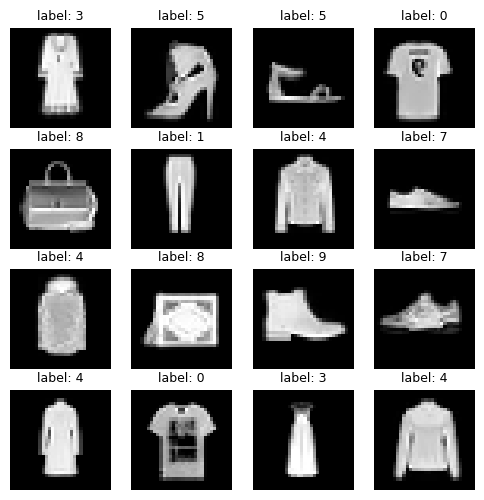

In [86]:
def show_clothes(Xtrain, ytrain):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))

    axes = axes.flatten()
    for img_vec, label, ax in zip(Xtrain.iloc[:16].to_numpy(), ytrain[:16], axes):
        ax.axis('off')
        ax.imshow(img_vec.reshape(32, 32), cmap='gray')
        ax.set_title(f"label: {label}", fontsize=9)
    plt.show()
show_clothes(Xtrain, ytrain)

Pro každý z prvních 16 obrázků zobrazíme histogram rozložení hodnot pixelů.
Y-osa je v logaritmické škále, aby byly lépe vidět vzácné intenzity.

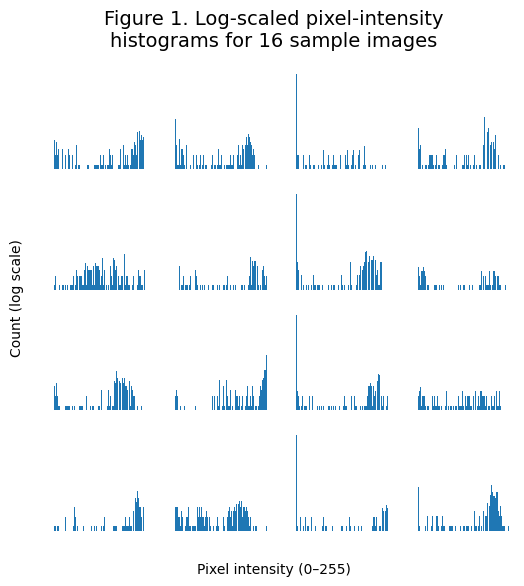

In [87]:
def show_pixels_hist(Xtrain):
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    axes = axes.flatten()
    fig.suptitle(
        "Figure 1. Log‐scaled pixel‐intensity\nhistograms for 16 sample images",
        fontsize=14, y=0.98
    )
    for img_vec, ax in zip(Xtrain.iloc[:16].to_numpy(), axes):
        ax.axis('off')
        ax.set_yscale('log')
        ax.hist(img_vec, bins=256)
    fig.text(0.5, 0.04, 'Pixel intensity (0–255)', ha='center')
    fig.text(0.06, 0.5, 'Count (log scale)', va='center', rotation='vertical')
    plt.show()
show_pixels_hist(Xtrain)

Zjistíme, zda jsou třídy v `ytrain` rozloženy přibližně rovnoměrně, vykreslením sloupcového grafu počtů vzorků v každé třídě.

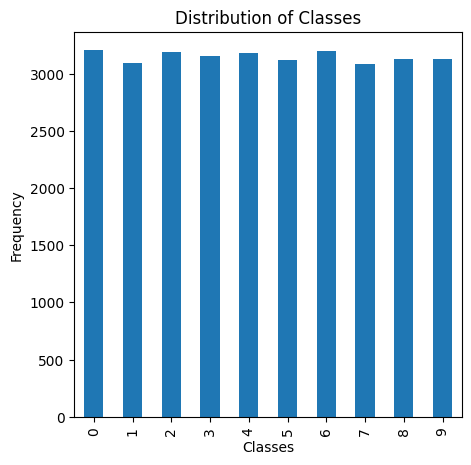

In [88]:
fig, ax = plt.subplots(figsize=(5, 5))
label_counts = ytrain.value_counts().sort_index()
label_counts.plot( kind='bar')
ax.set_title("Distribution of Classes")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticks(label_counts.index)
plt.show()

# Standardizace/noralizace dat

- **Min–Max Scaler**: škáluje pixely z původních `[0–255]` do `[0–1]`, zachová tvar distribuce.

- **Standard Scaler**: převede vstupy na nulový průměr a jednotkovou odchylku, čímž se odstraní posun a zlepší stabilita a rychlost konvergence při tréninku.


In [30]:
def make_normalization_standardization(Xtrain, y_train_labels, Xval, y_val_labels, cls_normalization_standadization):
    if cls_normalization_standadization is None:
        raise RuntimeError("expect cls_normalization_standadization to be not None")
    scaler = cls_normalization_standadization()
    Xtrain = scaler.fit_transform(Xtrain)
    Xval = scaler.transform(Xval)

    df_torch_X_train = torch.Tensor(Xtrain.astype(np.float32)).to(device)
    df_torch_y_train_labels = torch.Tensor(y_train_labels.to_numpy()).to(device).long()

    df_torch_X_val = torch.Tensor(Xval.astype(np.float32)).to(device)
    df_torch_y_val_labels = torch.Tensor(y_val_labels.to_numpy()).to(device).long()

    return TensorDataset(df_torch_X_train, df_torch_y_train_labels), TensorDataset(df_torch_X_val, df_torch_y_val_labels)

train_data_Standard_scaled, val_data_Standard_scaled = make_normalization_standardization(Xtrain, ytrain, Xval, yval, cls_normalization_standadization=StandardScaler)
train_data_MinMax_scaled,  val_data_MinMax_scaled= make_normalization_standardization(Xtrain, ytrain, Xval, yval, cls_normalization_standadization=MinMaxScaler)

Vytvoříme `TensorDataset` na data, na která jsme neaplikovali žádnou normalizaci či standardizaci.

In [31]:
train_data, val_data = (TensorDataset(torch.from_numpy(Xtrain.to_numpy()).float().to(device),  torch.from_numpy(ytrain.to_numpy()).long().to(device)),
                        TensorDataset(torch.from_numpy(Xval.to_numpy()).float().to(device),    torch.from_numpy(yval.to_numpy()).long().to(device)) )
type(train_data), type(train_data)

(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.dataset.TensorDataset)

#  Pomocné funkce pro trénink a vyhodnocení modelu


Provedeme jeden průchod (epoch) nad trénovací množinou: nastavíme model do režimu tréninku, provede forward pass, spočítáme ztrátu, zpětnou propagaci gradientů, update vah a případně krok learning rate scheduleru.

In [33]:
def train_one_epoch(model, train_loader, optimizer, scheduler=None):
    model.train()
    losses_train = []
    for X, y in train_loader:
        optimizer.zero_grad()
        preds = model(X)
        loss  = loss_fn(preds, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None and isinstance(scheduler, OneCycleLR):
            scheduler.step()
        losses_train.append(loss.item())

    return losses_train

Opakujeme trénink přes více epoch, volitelně vyhodnocujeme na validační sadě, podporuje melearning rate scheduler i jednoduchý early-stopping po K nelepších epochách.

In [34]:
def train_epochs(model, loss_fn, optimizer, epochs, train_loader, scheduler=None, val_loader=None, evaluated=False, K_epochs = 5):

    losses_train = []
    list_acc_val = []
    cnt_no_impovement = 0
    best_acc = -1
    for epoch in range(epochs):
        losses_train.extend(train_one_epoch(model=model, scheduler=scheduler, train_loader=train_loader, optimizer=optimizer))
        model.eval()
        running_loss = 0.0
        n_correct   = 0
        n_total     = 0
        if evaluated:
            with torch.no_grad():
                for X, y in val_loader:
                    logits = model(X)
                    loss   = loss_fn(logits, y)
                    running_loss += loss.item() * X.size(0)
                    n_total     += X.size(0)
                    preds = logits.argmax(dim=1)
                    n_correct += (preds == y).sum().item()
                accuracy = n_correct   / n_total
            list_acc_val.append(accuracy)

        if scheduler is not None and not isinstance(scheduler, OneCycleLR):
            scheduler.step()


        if evaluated and  list_acc_val[-1] > best_acc:
            best_acc = list_acc_val[-1]
            cnt_no_impovement = 0
        elif evaluated:
            cnt_no_impovement += 1
        if cnt_no_impovement > K_epochs:
            break
    return losses_train, list_acc_val

Provedeme kompletní vyhodnocení modelu na validační sadě: přesnost, ztrátu.

In [35]:
def evaluate(model, val_loader, loss_fn):
    model.eval()
    running_loss = 0.0
    n_correct   = 0
    n_total     = 0

    with torch.no_grad():
        for X, y in val_loader:
            logits = model(X)
            loss   = loss_fn(logits, y)
            running_loss += loss.item() * X.size(0)
            n_total     += X.size(0)
            preds = logits.argmax(dim=1)
            n_correct += (preds == y).sum().item()
    accuracy = n_correct   / n_total
    error_rate = 1.0 - accuracy

    return  accuracy, error_rate

# Dopředná neuronová síť

Dopředná neuronová síť je vhodný, protože
- se implementuje na pár řádků. Je dobrý jako výchozí bod před složitějšími architekturami (CNN, VGG).
- abychom zjistili dolní hranici úspěšnosti neuronových sítí. Má vůbec smysl investovat čas do realizaci složitějších modelů.

## Implementace Modelu

- **Vícevrstvá perceptronová (feed-forward) síť** sestavená pomocí `nn.Sequential`.
- **ReLU** zajišťuje nelinearitu a zrychluje konvergenci.
- **Dropout** po každé skryté vrstvě působí jako regularizace, snižuje přeučení.
- **Xavier uniform inicializace** (`nn.init.xavier_uniform_`) pro váhy hustých vrstev – udržuje stabilní velikost gradientů napříč vrstvami.
- Metoda **`forward`** pouze předá vstup skrz `self.net`, takže inference i trénink probíhají jedním voláním.

In [36]:
class Net(torch.nn.Module):
    def __init__(self,
                 input_size    = 1024,
                 hidden_sizes  = (512, 256, 128),
                 output_size   = 10,
                 activation_fn = nn.ReLU,
                 dropout       = 0.3):
        super().__init__()
        layers = []
        in_f = input_size
        for h in hidden_sizes:
            layers += [nn.Linear(in_f, h), activation_fn()]
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_f = h
        layers.append(nn.Linear(in_f, output_size))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def forward(self, x):
        return self.net(x)


Každá další vrstva bude zmenšena/zvětšená o zadaný poměr vůči předchozí, dokud nedosáhneme zadané hloubky nebo počtu neuronů < 10.

In [37]:
def neuron_hidden_layer(input_layer, depth, ratio_of_each_layer):
    res = (input_layer,)
    for i in range(depth - 1):
        if(math.floor(res[-1] * ratio_of_each_layer) < 10):
            break
        res += (math.floor(res[-1] * ratio_of_each_layer),)
    return res

neuron_hidden_layer(32, 3, 0.7)

(32, 22, 15)

## Ladění hyperparamtrů

1. Definice prostoru parametrů (`param_grid`)
   - Umožňuje jednoduše měnit hloubku sítě (`hidden layers size`), šířku vrstev (`ratio of each layer`, `first hiden layer`),
     regularizaci (`dropout`, `weight_decay`), optimalizátor i learning-rate.
   - Pole `"data"` lze přepínat mezi různě škálovanými verzemi (raw, Min–Max, Standard).

2. Iterace přes všechny kombinace (`ParameterGrid`)
   - Pro každou kombinaci vytvoříme DataLoader s patřičným batch-sizem.
   - Pomocí funkce `neuron_hidden_layer` dynamicky sestavíme skryté vrstvy.

3. Sestavení a trénink modelu
   - Konstruujeme instanci `Net` s daným dropoutem; aktivujeme vybraný optimalizátor (Adam nebo RMSprop) a trénujeme 10 epoch
     včetně jednoduchého early-stopping (`K_epochs=3`). Tím testujeme různé optimalizační metody i regularizační techniky.

4. Vyhodnocení a uložení nejlepší varianty

In [38]:
import torch.optim as optim
param_grid = {
              "data"                : [[train_data, val_data], [train_data_MinMax_scaled, val_data_MinMax_scaled], [train_data_Standard_scaled, val_data_Standard_scaled]],
              "batch size"          : [64, 128],
              "first hiden layer": [1024],
              'hidden layers size': [2, 3, 4],
              "ratio of each layer" : [0.5, 0.7],
              "dropout": [0.1, 0.2],
              "learning_rate": [1e-5],
              "optimizer"    : ["Adam", "RMSprop"],
              "weight_decay": [0.0, 1e-5]
              }

all_params = ParameterGrid(param_grid)
best_params_mlp = None
best_score_fnn_val = -1
model_path = "BestModels/best_model_mpl.pt"
epochs = 10
best_model_fnn = None
best_parametrs_fnn = None

for param in tqdm(all_params):
    x_data, y_data = param["data"]
    train_loader = torch.utils.data.DataLoader(x_data, batch_size=param["batch size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(y_data, batch_size=param["batch size"], shuffle=False)

    dropout = param['dropout']
    hidden_layers = param['hidden layers size']
    ratio = param['ratio of each layer']
    learning_rate = param['learning_rate']
    weight_decay = param['weight_decay']
    loss_fn = CrossEntropyLoss()

    opt_cls = getattr(optim, param["optimizer"])
    model = Net(dropout=dropout, hidden_sizes=neuron_hidden_layer(param["first hiden layer"], hidden_layers, ratio)).to(device)
    optimizer = opt_cls(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    losses_train, losses_val =  train_epochs(model, loss_fn, optimizer, epochs, train_loader=train_loader, K_epochs=3)
    accuracy, _  = evaluate(model, val_loader, loss_fn)
    if accuracy > best_score_fnn_val :
        best_params_mlp = param
        best_score_fnn_val = accuracy
        best_model_fnn = model
        best_parametrs_fnn = param
        #torch.save(model.state_dict(), model_path)

100%|██████████| 288/288 [49:21<00:00, 10.28s/it]


Uložíme případně nejlepší model

In [59]:
file_path_best_models_fnn = file_path_best_models + "/best_model_fnn.pt"
file_path_best_models_fnn

'/content/drive/My Drive/Colab Notebooks/BestModels/best_model_fnn.pt'

In [60]:
torch.save(best_model_fnn.state_dict(), file_path_best_models_fnn)

In [46]:
best_params_mlp, best_score_fnn_val

({'batch size': 64,
  'data': [<torch.utils.data.dataset.TensorDataset at 0x7dd9e811d450>,
  'dropout': 0.1,
  'first hiden layer': 1024,
  'hidden layers size': 4,
  'learning_rate': 1e-05,
  'optimizer': 'RMSprop',
  'ratio of each layer': 0.7,
  'weight_decay': 0.0},
 0.8091836734693878)

In [41]:
#model = torch.load("BestModels/best_model_mpl.pt")

# Konvoluční síť

Zkusíme dva typy konvoluční sítě.
1. **ConvFeatureExtractor**. Nejprve postavíme bloky konvolucí a poolingu, které vytvoří "bohatší" příznaky; na ty pak navážeme dopřednou neuronovou síť.
2. **VGG-style síť** . Zmenšená verze známé architektury VGG, která má přesnost přes 90% na ImageNet. Inspirace tímto zdrojem : https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

Tento model je vhodný, protože
- Umí detekovat lokální tvary (rukáv, podrážka, švy) i hrany objektů.
- Konvoluční filtry vnímají sousedství pixelů.
- Díky poolingům pozná kus oblečení i mimo střed obrázku.
- potřebuje míň parametrů. Tím se snižuje riziko přeučení a rychleší trenink.

## ConvFeatureExtractor

Definujeme nejmenší stavební kámen konvoluční části.

In [42]:
def make_convolutional_block(
        in_channels,
        out_channels,
        kernel_size=3,
        use_dropout=False,
        dropout_p=0.2,
        activation=nn.ReLU,
        norm_layer=nn.BatchNorm2d,
        stride=1,
        pool=None
):

    layers = []
    conv = nn.Conv2d(
        in_channels=in_channels,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        padding=kernel_size // 2,
        bias=False,
    )

    layers.append(conv)
    if norm_layer is not None:
        layers.append(norm_layer(out_channels))
    layers.append(activation())
    if use_dropout:
        layers.append(nn.Dropout2d(dropout_p))

    if pool == 'max':
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    elif pool == 'avg':
        layers.append(nn.AvgPool2d(kernel_size=2, stride=2))

    return nn.Sequential(*layers)

Spojíme více konvolučních bloků do jediné třídy, která funguje jako extraktor bohatých příznaků.


In [43]:
class ConvolutionalBlocks(nn.Module):
    def __init__(
            self,
            layers: int = 3,
            first_hidden_layer: int = 64,
            ratio_hidden_layers: float = 2,
            kernel_size: int = 3,
            use_dropout: bool = True,
            dropout_p: float = 0.2,
            activation: nn.Module = nn.ReLU,
            normal_layer: nn.Module = nn.BatchNorm2d,
            stride: int = 1,
            pool: str = "max",
            input_channels: int = 1,
            input_size = (32,32),
            has_own_classifier: bool = False
    ):
        super().__init__()
        if ratio_hidden_layers <= 1:
            raise ValueError("ratio_hidden_layers must be > 1")

        self.input_channels = input_channels
        self.input_size     = input_size

        in_ch  = input_channels
        out_ch = int(first_hidden_layer)
        blocks = []

        for _ in range(layers):
            blocks.append(
                make_convolutional_block(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=stride,
                    use_dropout=use_dropout,
                    dropout_p=dropout_p,
                    norm_layer=normal_layer,
                    activation=activation,
                    pool=pool,
                )
            )
            in_ch  = out_ch
            out_ch = int(out_ch * ratio_hidden_layers)


        self.features = nn.Sequential(*blocks)

        with torch.no_grad():
            dummy = torch.zeros(1,
                                self.input_channels,
                                *self.input_size)
            out   = self.features(dummy)
        _, C_out, H_out, W_out = out.shape
        self.out_shape = (C_out, H_out, W_out)
        self.channels  = C_out
        if has_own_classifier:
            self.classifier = nn.Identity()
        else:
            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(C_out * H_out * W_out, 10)
            )

    def forward(self, x: torch.Tensor):
        if x.dim() == 2:
            B, _ = x.shape
            C, H, W = self.input_channels, *self.input_size
            x = x.view(B, C, H, W)

        return self.classifier(self.features(x))

Spojí extraktor z buňky 2 s malým **MLP**, čímž dostáváme první typ konvoluční sítě.

In [44]:
class ConvThenMLP(nn.Module):
   def __init__(self,
            conv_layers:             int = 3,
            conv_first_hidden:       int = 64,
            conv_ratio_hidden:       float = 2,
            conv_kernel_size:        int = 3,
            conv_use_dropout:        bool = False,
            conv_dropout_p:          float = 0.2,
            conv_activation:         nn.Module = nn.ReLU,
            conv_stride:             int = 1,
            conv_pool:               str = "max",
            normal_layer: nn.Module = nn.BatchNorm2d,

            input_channels:          int = 1,
            input_size:             tuple[int,int] = (32,32),

            mlp_hidden_sizes:       tuple[int,...] = (512,256,128),
            mlp_dropout:            float = 0.3,
            mlp_output_size:        int   = 10,
   ):
        super().__init__()

        self.conv_extractor = ConvolutionalBlocks(
            layers               = conv_layers,
            first_hidden_layer   = conv_first_hidden,
            ratio_hidden_layers  = conv_ratio_hidden,
            kernel_size          = conv_kernel_size,
            use_dropout          = conv_use_dropout,
            activation           = conv_activation,
            stride               = conv_stride,
            pool                 = conv_pool,
            normal_layer         = normal_layer,
            input_channels       = input_channels,
            input_size           = input_size,
            has_own_classifier = True,
        )

        C_out, H_out, W_out = self.conv_extractor.out_shape
        flat_dim = C_out * H_out * W_out

        self.mlp = Net(
            input_size    = flat_dim,
            hidden_sizes  = mlp_hidden_sizes,
            output_size   = mlp_output_size,
            activation_fn = nn.ReLU,
            dropout       = mlp_dropout,
        )

   def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 2:
            B, D = x.shape
            C, H, W = self.conv_extractor.input_channels, *self.conv_extractor.input_size
            x = x.view(B, C, H, W)

        feat = self.conv_extractor(x)
        flat = feat.view(feat.size(0), -1)

        return self.mlp(flat)

### Ladění hyper-parametrů

1. **Definice prostoru parametrů (`conv_grid_first_type`)**

   - Vycházíme ze společného slovníku `shared`, který nám dovoluje měnit
     - hloubku sítě (`layers`),
     - šířku prvního bloku (`first_hidden_layer`) i poměr rozšiřování (`ratio_hidden_layers`),
     - regularizaci (`dropout`, `weight_decay`),
     - optimalizátor (`optimizer`) a `learning_rate`,
     - případně normalizační vrstvu (`norm_layer`).
   - Pole `"data"` lze přepínat mezi různě škálovanými verzemi datasetu (raw / Min-Max / Standard).
   - Kombinováním `grid_no_dropout` a `grid_with_dropout` testujeme s i bez dropoutu.

2. **Iterace přes všechny kombinace** (`ParameterGrid`)

3. **Sestavení a trénink modelu**

4. **Vyhodnocení na validační sadě a uložení nejlepší varianty**

In [47]:
shared = {
    "data"                : [[train_data, val_data], [train_data_MinMax_scaled, val_data_MinMax_scaled], [train_data_Standard_scaled, val_data_Standard_scaled]],
    "batch size"          : [128],
    "layers"              : [2,3],
    "first_hidden_layer"  : [64],
    "ratio_hidden_layers" : [1.5, 2],
    "learning_rate"       : [1e-2, 3e-4],
    "weight_decay"        : [0.0, 1e-5],
    "activation"          : [nn.ReLU, nn.LeakyReLU],
    "norm_layer"          : [None, nn.BatchNorm2d],
    "optimizer"           : ["Adam", "RMSprop"],
    "stride"              : [1],
    "pool"                : ["max"]
}

grid_no_dropout = {
    **shared,
    "use_dropout": [False],
    "dropout_p"  : [0.0],
}

grid_with_dropout = {
    **shared,
    "use_dropout": [True],
    "dropout_p"  : [0.2],
}
model_path_conv = "./BestModels/best_model_conv.pt"

conv_grid_first_type = [grid_no_dropout, grid_with_dropout]
best_model_conv = None
best_params_conv = None
epochs=10
best_score_conv_val = -1
best_losses_val_conv = -1
for parameter in tqdm(ParameterGrid(conv_grid_first_type)):
    x_data, y_data = parameter["data"]
    train_loader = torch.utils.data.DataLoader(x_data, batch_size=parameter["batch size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(y_data, batch_size=parameter["batch size"], shuffle=False)

    layers = parameter["layers"]
    first_hidden_layer = parameter["first_hidden_layer"]
    ratio_hidden_layers = parameter["ratio_hidden_layers"]
    use_dropout = parameter["use_dropout"]
    dropout_p = parameter["dropout_p"]
    learning_rate = parameter["learning_rate"]
    weight_decay = parameter["weight_decay"]
    activation = parameter["activation"]
    norm_layer = parameter["norm_layer"]
    stride = parameter["stride"]
    pool = parameter["pool"]


    cls_optim = getattr(optim, parameter["optimizer"])
    model = ConvThenMLP(conv_layers=layers,
                        conv_first_hidden=first_hidden_layer,
                        conv_ratio_hidden=ratio_hidden_layers,
                        conv_use_dropout=use_dropout,
                        conv_dropout_p=dropout_p,
                        conv_activation=activation,
                        normal_layer=norm_layer,
                        conv_stride=stride,
                        conv_pool=pool,
                        mlp_hidden_sizes=neuron_hidden_layer(32, 3, 0.7),
                        mlp_dropout=dropout_p,
                        ).to(device)

    optimizer = cls_optim(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    losses_train, _ = train_epochs(model, loss_fn, optimizer, epochs, train_loader=train_loader, K_epochs=5)
    accuracy, _  = evaluate(model, val_loader, loss_fn)
    if accuracy > best_score_conv_val :
        best_model_conv = model
        best_params_conv = parameter
        best_score_conv_val = accuracy
        best_params_conv = parameter
        #torch.save(model.state_dict(), model_path_conv)

100%|██████████| 768/768 [3:07:20<00:00, 14.64s/it]


In [49]:
best_params_conv

{'activation': torch.nn.modules.activation.LeakyReLU,
 'batch size': 128,
 'data': [<torch.utils.data.dataset.TensorDataset at 0x7dd9d7f19590>,
 'dropout_p': 0.0,
 'first_hidden_layer': 64,
 'layers': 3,
 'learning_rate': 0.0003,
 'norm_layer': torch.nn.modules.batchnorm.BatchNorm2d,
 'optimizer': 'RMSprop',
 'pool': 'max',
 'ratio_hidden_layers': 2,
 'stride': 1,
 'use_dropout': False,
 'weight_decay': 0.0}

Nejlepší model má přesnost na validační množíně :

In [51]:
best_score_conv_val

0.894421768707483

Uložíme případně nejlepší model.

In [57]:
file_path_best_models_conv = file_path_best_models + "/best_model_conv.pt"
file_path_best_models_conv

'/content/drive/My Drive/Colab Notebooks/BestModels/best_model_conv.pt'

In [58]:
torch.save(best_model_conv.state_dict(), file_path_best_models_conv)

## VGG-style síť

- **Mini-VGG sítˇ**: kopíruje princip VGG-11/13 (dvojice 3×3 konvolucí + pooling), ale je zmenšená pro 28 px snímky.
- **Batch-Norm** po každé konvoluci stabilizuje učení, ReLU přidává nelinearitu.
- **Adaptive pooling** odstraňuje závislost na přesné velikosti obrazu.
- **Flexibilní vstup**: akceptuje i „rozflattenovaný“ vektor `[B, 1024]` a sám jej přetvaruje zpět na 28 × 28.

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VGG(nn.Module):
    def __init__(self, num_classes: int = 10, in_channels: int = 1):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),

                nn.Conv2d(out_c, out_c, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),

                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(in_channels,  32),           # 28→14
            block(32,            64),          # 14→7
            block(64,           128),          # 7 →3
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),                      # →128
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),

            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        if x.ndim == 2:
            B, D = x.shape
            side = int(D ** 0.5)
            x = x.view(B, 1, side, side)

        x = self.features(x)
        x = self.avgpool(x)
        logits = self.classifier(x)
        return logits


### Ladění hyper-parametrů

1. **Definice prostoru parametrů** (`param_grid`)

   *Vyrábíme jej kartézským součtem dvou sad (`adamw_grid` + `sgd_grid`) a společného vstupu `data_input`.*

   - **Optimalizátor** (`optim`) · `AdamW` **vs.** `SGD`
   - **Learning-rate** (`lr`) · `1e-4` pro AdamW, `0.01` pro SGD
   - **Weight-decay** (`weight_decay`) · `0.0` (AdamW) / `5e-4` (SGD)
   - **LR-scheduler** (`lr_schedule`) · `cosine` *(případně `onecycle`)*
   - **Momentum / Nesterov** (jen pro SGD) · `momentum = 0.9`, `nesterov = False`
   - **Batch-size** (`batch size`) · `128`
   - **Data** (`data`) · aktuálně Min-Max škálovaná verze (lze přepnout na Standard)

2. **Iterace přes všechny kombinace** (`ParameterGrid`)

3. **Sestavení a trénink modelu**

4. **Vyhodnocení na validační sadě a uložení nejlepší varianty**

In [62]:
import torch.optim as optim
adamw_grid = [
    {
        "optim"        : ["AdamW"],
        "lr"           : [1e-4, 3e-4, 1e-3],
        "weight_decay" : [0.0, 1e-4, 3e-4],
        "lr_schedule"  : ["cosine", "onecycle"],
    }
]
sgd_grid = [
    {
        "optim"        : ["SGD"],
        "lr"           : [0.01, 0.05],
        "momentum"     : [0.9],
        "nesterov"     : [False, True],
        "weight_decay" : [5e-4],
        "lr_schedule"  : ["cosine", "onecycle"],
    }
]

data_input = [ { "data"                : [[train_data, val_data], [train_data_MinMax_scaled, val_data_MinMax_scaled], [train_data_Standard_scaled, val_data_Standard_scaled]],
                 "batch size"          : [128]}]

param_grid = [
    { **model_grid, **d }
    for model_grid in (adamw_grid + sgd_grid)
    for d in data_input
]



loss_fn = nn.CrossEntropyLoss()
vgg_accurace = -1
vgg_best_params = None
epochs = 20
vgg_best_model = None
for parametrs in tqdm(ParameterGrid(param_grid)):
    x_data, y_data = parametrs["data"]
    train_loader = torch.utils.data.DataLoader(x_data, batch_size=parametrs["batch size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(y_data, batch_size=parametrs["batch size"], shuffle=False)

    model = VGG28().to(device)
    opt_cls  = getattr(torch.optim, parametrs["optim"])
    lr = parametrs["lr"]
    weight_decay = parametrs["weight_decay"]
    lr_schedule = parametrs["lr_schedule"]
    optim_1 = opt_cls(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = None
    if parametrs["lr_schedule"] == "cosine":
        scheduler = lr_scheduler.CosineAnnealingLR(
            optim_1, T_max=epochs
        )
    elif parametrs["lr_schedule"] == "onecycle":
        scheduler = lr_scheduler.OneCycleLR(
            optim_1,
            max_lr=parametrs["lr"] * 10,
            steps_per_epoch=len(train_loader),
            epochs=epochs,
            pct_start=0.3
        )
    loss_fn = CrossEntropyLoss()
    _, val_accs_2 = train_epochs(model=model, loss_fn=loss_fn, train_loader=train_loader, optimizer=optim_1, epochs=epochs, evaluated=False, scheduler=scheduler)
    accuracy, _  = evaluate(model, val_loader, loss_fn)
    if vgg_accurace < accuracy:
        vgg_accurace =  accuracy
        vgg_best_model = model
        vgg_best_params = parametrs
vgg_accurace

100%|██████████| 78/78 [41:29<00:00, 31.92s/it]


0.9239455782312925

Nejlepší model má přesnost na validační množíně :

In [89]:
vgg_accurace

0.9239455782312925

Uložíme případně nejlepší model.

In [64]:
file_path_best_models_vgg = file_path_best_models + "/best_model_vgg.pt"
file_path_best_models_vgg

'/content/drive/My Drive/Colab Notebooks/BestModels/best_model_vgg.pt'

In [65]:
torch.save(vgg_best_model.state_dict(), file_path_best_models_vgg)

# Volba modelu

Podíváme se na validační množinu tří modelu (dopředné neuronové síťě, konvoluční síťě prvního a druhé typu).


In [67]:
best_score_fnn_val, best_score_conv_val,vgg_accurace

(0.8091836734693878, 0.894421768707483, 0.9239455782312925)

VGG-style síť vyhrává.

Teď uděláme predikci na testovacích datech.

In [68]:
vgg_best_params

{'batch size': 128,
 'data': [<torch.utils.data.dataset.TensorDataset at 0x7dd9d7f19590>,
 'lr': 0.05,
 'lr_schedule': 'onecycle',
 'momentum': 0.9,
 'nesterov': True,
 'optim': 'SGD',
 'weight_decay': 0.0005}

Podíváme, jestli model potřebuje standardizaci nebo normalizaci k tomu, aby mohl predikovat. Případně ji uděláme.


In [71]:
print(train_data_MinMax_scaled == vgg_best_params["data"][0])
print(train_data_Standard_scaled == vgg_best_params["data"][0])
print(train_data == vgg_best_params["data"][0])

True
False
False


In [72]:
X_train_t, y_train_t = train_data.tensors
X_train_np = X_train_t.detach().cpu().numpy()

In [74]:
temp_min_max_scaler = MinMaxScaler()
temp_min_max_scaler.fit(X_train_np)
temp_transformed = temp_min_max_scaler.transform(Xtest.to_numpy())
test_data = TensorDataset( torch.Tensor(temp_transformed.astype(np.float32)).to(device), torch.from_numpy(ytest.to_numpy()).long().to(device) )

Na testovací množíně jsme získali přesnost 92,2%. Druhé číslo, kolem 7%, je doplňěk přesnosti. Říká jen, kolik nám chybí do 100%.

In [75]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=vgg_best_params["batch size"], shuffle=False)
loss_fn = CrossEntropyLoss()
evaluate(vgg_best_model, test_loader, loss_fn=loss_fn)

(0.922063492063492, 0.07793650793650797)

# Vyhodnocavací data

 Nejdříve načteme soubor.

In [77]:
file_path_evaluate = "/content/drive/My Drive/Colab Notebooks/evaluate.csv"

In [78]:
eval = pd.read_csv(file_path_evaluate)
eval

,ID,pix1,pix2,pix3,pix4,pix5,pix6,pix7,pix8,pix9,...,pix1015,pix1016,pix1017,pix1018,pix1019,pix1020,pix1021,pix1022,pix1023,pix1024
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17495,17495,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
17496,17496,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17497,17497,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17498,17498,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [79]:
image = eval.iloc[:, 1:]
ids = eval.iloc[:, 0]

Aplikujeme na vstupní obrázky transformaci, aby mohl nejlepší model predikovat.

In [80]:
temp_min_max_scaler_transformed = temp_min_max_scaler.transform(image.to_numpy())

In [81]:
eval_dataset = TensorDataset(torch.Tensor(temp_min_max_scaler_transformed.astype(np.float32)).to(device))
eval_loader  = DataLoader( eval_dataset, batch_size=128, shuffle=False)

Spočítáme predikce pro data ze souboru evaluate.csv, zobrázíme si výsledky predikce a uložíme si je do result.csv.

In [82]:
vgg_best_model.eval()
all_preds = []
with torch.no_grad():
    for batch in eval_loader:
        x_batch = batch[0]
        logits  = vgg_best_model(x_batch)
        preds   = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)

res = pd.DataFrame({
    "ID":    ids,
    "label": all_preds
})

In [83]:
res.iloc[:10,:]

,ID,label
0,0,4
1,1,8
2,2,5
3,3,0
4,4,3
5,5,4
6,6,7
7,7,7
8,8,8
9,9,6


In [85]:
res.to_csv("/content/drive/My Drive/Colab Notebooks/result.csv", index=False)